# Retail Store Performance Analysis

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Establish the connection
conn_string = (
    "Driver={SQL Server};"
    "Server=DESKTOP-IV08R9B\\SQLEXPRESS;"
    "Database=Target;"
    "Trusted_connection=yes;"
)

In [3]:
# Function to run queries through my database
def run_sql(query, conn_string=conn_string):
    try:
        # Connect to the database
        conn = pyodbc.connect(conn_string)
        
        # Create a cursor object
        cursor = conn.cursor()
        
        # Execute the SQL query
        cursor.execute(query)
        
        # Check if the query returned a result set
        if cursor.description is not None:
            # Fetch all rows
            data = cursor.fetchall()

            if len(data) > 0:
                # Get column names from cursor description
                columns = [column[0] for column in cursor.description]
                
                # Create a DataFrame from the fetched data and column names
                df = pd.DataFrame([tuple(row) for row in data], columns=columns)
                
                return df
            else:
                print("The query returned no results.")

        else:
            # Commit the transaction if needed
            conn.commit()
            print("Query executed successfully.")
            
    except pyodbc.Error as e:
        sqlstate = e.args[0] if e.args else None
        print(f"An error occurred: SQL State: {sqlstate}, Error Message: {e}")

    finally:
        # Close the cursor and connection
        cursor.close()
        conn.close()

## Queries

### 1. Which store format has the highest average security incidents per store?

#### Objective:
To identify which store format experiences the highest average security incidents per store. This information could be crucial for decision-makers considering adjustments to security measures.

#### SQL Code:

In [4]:
query = """
SELECT 
    TOP 5 
    SI.Store_Format, 
    AVG(TC.Security_Incident_Count) AS Avg_Security_Incidents
FROM 
    Store_Information SI 
    INNER JOIN TruCase_Incidents TC ON SI.Store_Number = TC.Store_Number
GROUP BY 
    SI.Store_Format
ORDER BY 
    Avg_Security_Incidents DESC;
"""
df_query_1 = run_sql(query)

#### Output:
StoreFormat_47 has by far the highest average at 14 incidents per store followed by StoreFormat_03 at 3 incidents per store and StoreFormat_36 at 2 incidents per store.

In [5]:
df_query_1

,Store_Format,Avg_Security_Incidents
0,StoreFormat_47,14
1,StoreFormat_03,3
2,StoreFormat_36,2
3,StoreFormat_37,1
4,StoreFormat_40,1


#### Visualization:

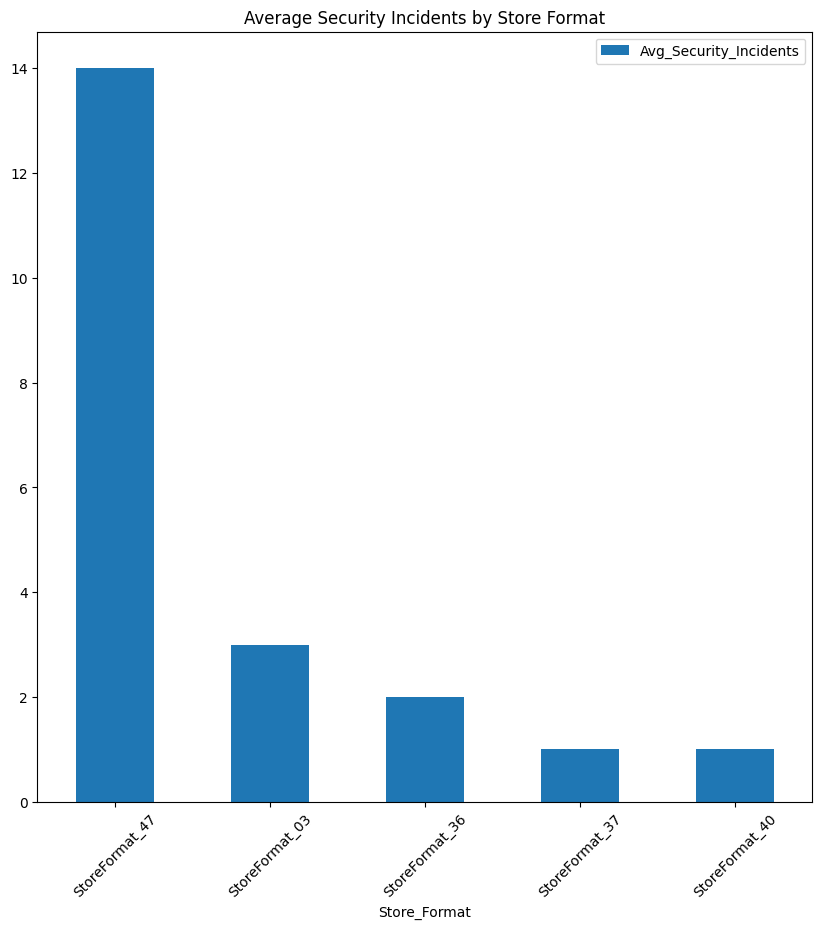

In [6]:
# Create the plot
ax = df_query_1.plot(x="Store_Format", y="Avg_Security_Incidents", kind='bar', title="Average Security Incidents by Store Format", figsize=(10,10))

# Rotate the x-tick labels by 45 degrees
ax.set_xticklabels(df_query_1["Store_Format"], rotation=45)

# Show the plot
plt.show()

#### Analysis:
Based on the data, we can see that StoreFormat_47 has by far the highest average security incidents per store. This information could be used to allocate more security resources to StoreFormat_47 stores.

### 2. Which states have the highest average recorded daily theft?

#### Objective:
To determine which states have the highest average recorded daily theft. Understanding this can help regional managers focus their loss prevention efforts.

#### SQL Code:

In [7]:
query = """
SELECT 
    TOP 10
    SI.State, 
    ROUND((SUM(TC.Total_Theft_Proven) / COUNT(TC.Incident_Month_Year)) / 30,2) AS Average_Daily_Theft
FROM 
    TruCase_Incidents TC 
    INNER JOIN Store_Information SI ON TC.Store_Number = SI.Store_Number
GROUP BY 
    SI.State
ORDER BY 
    Average_Daily_Theft DESC;
"""
df_query_2 = run_sql(query)

#### Output:
State_38 has the highest daily theft at $991.13 per store per day followed by State_03 and State_20.

In [8]:
df_query_2

,State,Average_Daily_Theft
0,State_38,991.13
1,State_03,802.19
2,State_20,796.59
3,State_41,794.43
4,State_26,771.40
5,State_21,584.47
6,State_30,551.42
7,State_34,512.40
8,State_14,488.16
9,State_24,448.99


#### Visualization:

[Text(0, 0, 'State_38'),
 Text(1, 0, 'State_03'),
 Text(2, 0, 'State_20'),
 Text(3, 0, 'State_41'),
 Text(4, 0, 'State_26'),
 Text(5, 0, 'State_21'),
 Text(6, 0, 'State_30'),
 Text(7, 0, 'State_34'),
 Text(8, 0, 'State_14'),
 Text(9, 0, 'State_24')]

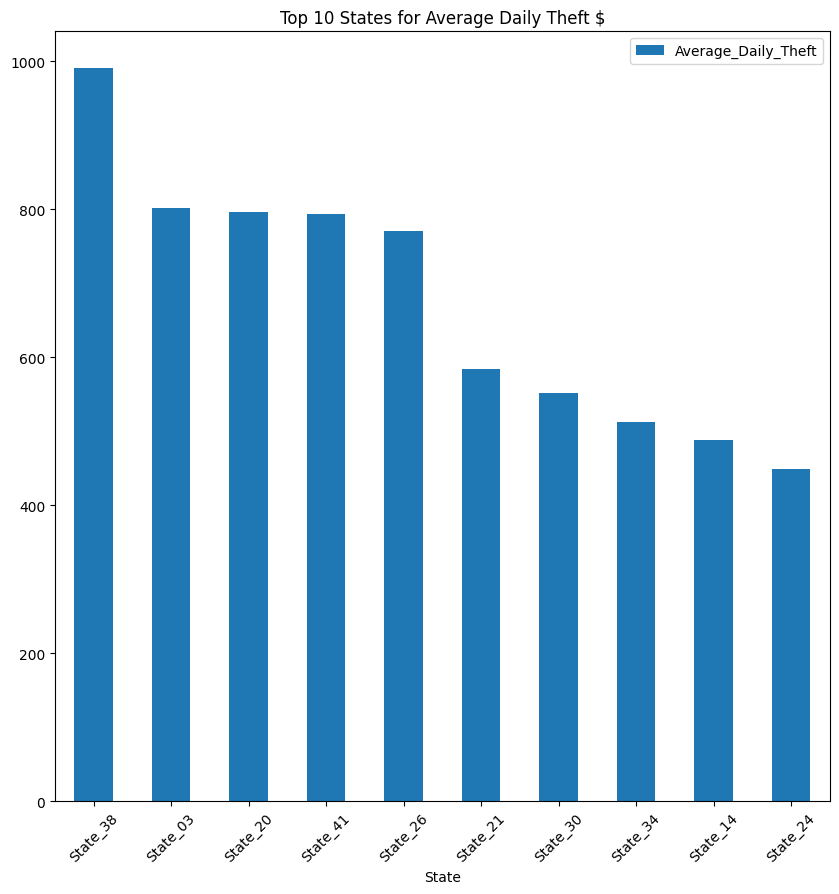

In [9]:
# Prepare the plot
ax = df_query_2.plot(
    x="State", 
    y="Average_Daily_Theft", 
    kind="bar", 
    title="Top 10 States for Average Daily Theft $", 
    figsize=(10, 10)
)

# Set x-tick labels with rotation
ax.set_xticklabels(df_query_2["State"], rotation=45)

#### Analysis:
The states with the highest average recorded daily theft are State_38, State_03, and State_20. Loss prevention initiatives might be more effectively focused on stores in these states.

### 3. Has the recent boycott actually affected our store?

#### Objective:
To assess the impact of a recent boycott campaign on our stores by comparing sales data before and after the boycott started.

#### SQL Code:

In [10]:
query = """
SELECT 
    YEAR(Sale_Week) AS Year, 
    MONTH(Sale_Week) AS Month, 
    ROUND(SUM(Sales), 2) as Total_Sales
FROM 
    Sales_MyStore
WHERE
    (YEAR(Sale_Week) = YEAR(GETDATE()) 
    OR YEAR(Sale_Week) = YEAR(GETDATE()) - 1
    OR YEAR(Sale_Week) = YEAR(GETDATE()) - 2)
    AND MONTH(Sale_Week) BETWEEN 5 and 7
GROUP BY
    YEAR(Sale_Week), 
    MONTH(Sale_Week)
ORDER BY 
    Year ASC, 
    Month ASC;
"""
df_query_3 = run_sql(query)

#### Output:
2023 has the lowest sales total over all three tracked years for the months of May, June, and July.

In [11]:
df_query_3

,Year,Month,Total_Sales
0,2021,5,2575229.18
1,2021,6,2286855.56
2,2021,7,2183358.84
3,2022,5,2499580.98
4,2022,6,2113931.31
5,2022,7,2736213.53
6,2023,5,1782920.42
7,2023,6,1868838.56
8,2023,7,1089515.23


#### Visualization:

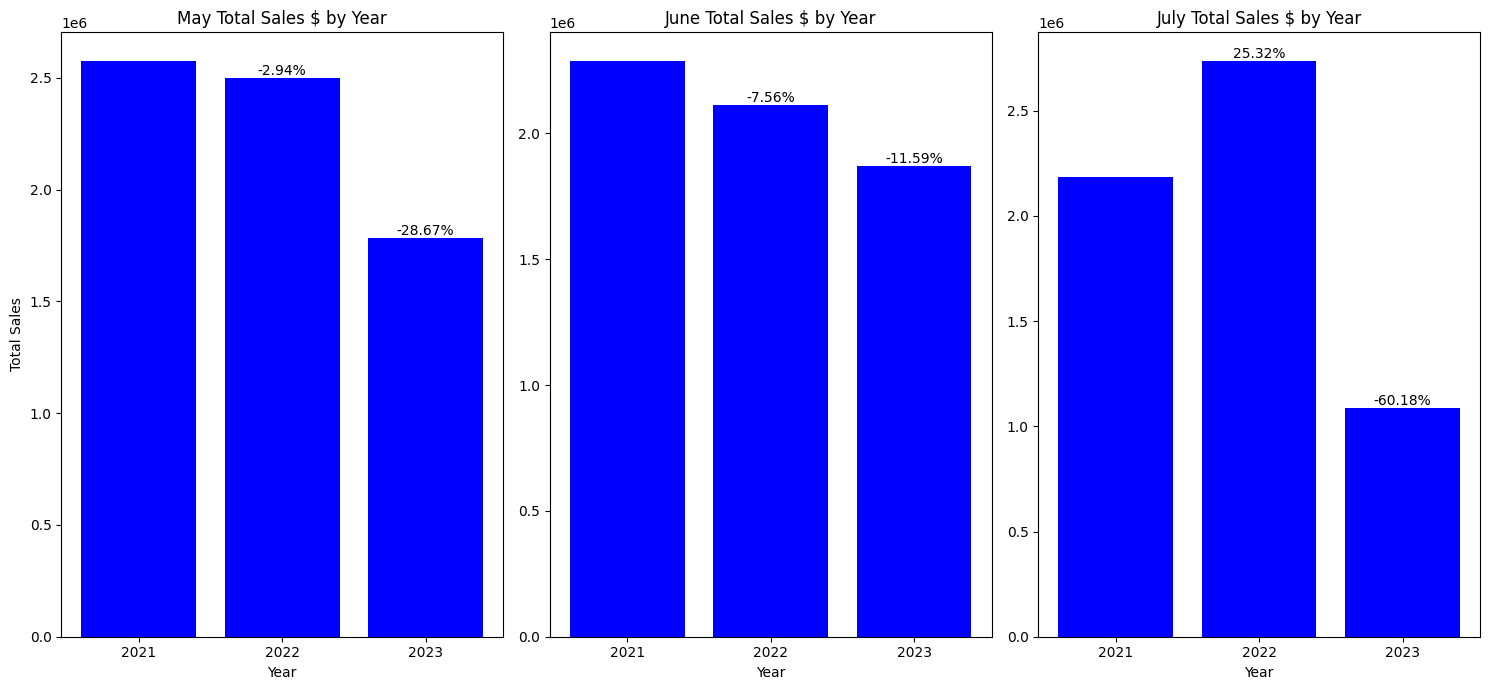

In [12]:
# Create a dictionary to map month numbers to month names
month_name_map = {5: 'May', 6: 'June', 7: 'July'}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Loop through each unique month
for index, month in enumerate(df_query_3['Month'].unique()):
    ax = axs[index]
    # Filter DataFrame for each specific month
    df_month = df_query_3[df_query_3['Month'] == month]

    # Sort by Year for plotting and calculations
    df_month = df_month.sort_values('Year')
    
    # Calculate YoY change
    df_month['YoY Change'] = df_month['Total_Sales'].pct_change() * 100

    # Plot data
    bars = ax.bar(df_month['Year'], df_month['Total_Sales'], color='blue')
    
    # Use month name instead of month number for the title
    month_name = month_name_map.get(month, f'Month {month}')
    ax.set_title(f"{month_name} Total Sales $ by Year")

    ax.set_xlabel('Year')
    
    # Set y-label only for the first subplot
    if index == 0:
        ax.set_ylabel('Total Sales')

    # Set x-ticks to only include unique years in the data for this month
    ax.set_xticks(df_month['Year'].unique())
    
    # Annotate with YoY change
    for bar, yoy in zip(bars, df_month['YoY Change']):
        height = bar.get_height()
        if not np.isnan(yoy):
            ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{yoy:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Analysis:
Sales have gradually been dropping year-over-year but drastically dropped in 2023. In May, the year-over-year drop by percentage was 28.67%, for June it was 11.59%, and for July it was a staggering 60.18% drop. If the question is "Did the boycott have any change in sales?", the answer seems to be yes.

### 4. Which employees have reported the most empty packages in the current month?

#### Objective:
To identify the employees who have reported the most empty packages in the current month. This could help in internal training and awareness programs.

#### SQL Code:

In [13]:
query = """
SELECT 
    TOP 10
    EI.Employee_ID, 
    ROUND(SUM(DI.Official_Retail_Price),2) AS Retail_Price_Sum,
    SUM(EP.Quantity) AS Number_of_Items
FROM 
    Employee_Info_MyStore EI 
    INNER JOIN Empty_Packages_MyStore EP ON EI.Employee_ID = EP.Reported_By_ID
    INNER JOIN DPCI_Info DI ON EP.DPCI = DI.DPCI
WHERE 
    MONTH(EP.Reported_Date) = (SELECT MONTH(MAX(Reported_Date)) FROM Empty_Packages_MyStore) 
    AND YEAR(EP.Reported_Date) = (SELECT YEAR(MAX(Reported_Date)) FROM Empty_Packages_MyStore)
GROUP BY 
    EI.Employee_ID
ORDER BY 
    Retail_Price_Sum DESC
"""
df_query_4 = run_sql(query)

#### Output:
EmployeeID_231 has the highest total retail price of $285.96, followed by EmployeeID_098 and EmployeeID_196.

In [14]:
df_query_4

,Employee_ID,Retail_Price_Sum,Number_of_Items
0,EmployeeID_231,285.96,20
1,EmployeeID_098,165.98,2
2,EmployeeID_196,130.43,11
3,EmployeeID_147,111.98,7
4,EmployeeID_109,104.98,2
5,EmployeeID_018,83.00,6
6,EmployeeID_220,69.99,5
7,EmployeeID_067,68.96,5
8,EmployeeID_178,64.97,4
9,EmployeeID_187,58.97,5


#### Visualization:

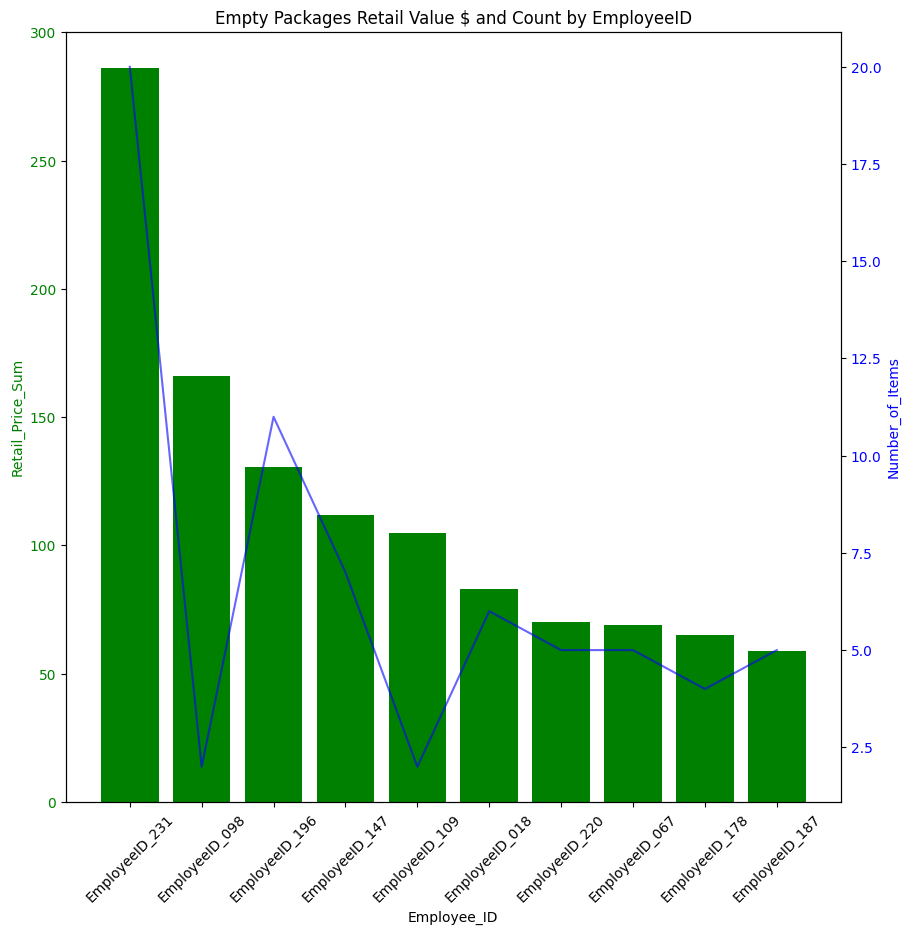

In [15]:
fig, ax1 = plt.subplots(figsize=(10,10))

# Plot Retail_Price_Sum as a line chart on the first y-axis
ax1.bar(df_query_4["Employee_ID"], df_query_4["Retail_Price_Sum"], color='g', label='Retail Price Sum')
ax1.set_xlabel('Employee_ID')
ax1.set_ylabel('Retail_Price_Sum', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Explicitly set x-ticks to match each unique Employee_ID and rotate for visibility
ax1.set_xticks(df_query_4["Employee_ID"])
ax1.set_xticklabels(df_query_4["Employee_ID"], rotation=45)

# Create the second y-axis
ax2 = ax1.twinx()

# Plot Number_of_Items as a bar chart on the second y-axis
ax2.plot(df_query_4["Employee_ID"], df_query_4["Number_of_Items"], color='b', label='Number of Items', alpha=0.6)
ax2.set_ylabel('Number_of_Items', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Add a title
plt.title('Empty Packages Retail Value $ and Count by EmployeeID')

# Show the plot
plt.show()

#### Analysis:
Employees 231, 098, and 196 have reported the most empty packages for the current month, suggesting they are vigilant or perhaps their sections are more prone to theft or loss. It is interesting to see that the second highest retail sum but only have two items recorded meaning a much higher average cost per item. This could be worth investigating.

## Stored Procedures

### Create a stored procedure to pull specific employee information

#### Objective:
To simplify the process of pulling comprehensive information about employees, including their employment history, roles, and current projects.

#### SQL Code:

In [16]:
# Drop stored procedure if it exists
query = "DROP PROCEDURE GetEmployeeDetails"
run_sql(query)

Query executed successfully.


In [17]:
# Create stored procedure to pull employee information
query = """
CREATE PROCEDURE GetEmployeeDetails 
    @EmployeeID VARCHAR(20)
AS
BEGIN
    SELECT * 
    FROM Employee_Info_MyStore
    WHERE Employee_ID = @EmployeeID;
END;
"""
run_sql(query)

Query executed successfully.


#### Usage:
To call the stored procedure, use `EXEC GetEmployeeInfo @EmployeeID = "EmployeeID_XXX";`

In [18]:
# Execute stored procedure on EmployeeID_001
query = "EXEC GetEmployeeDetails @EmployeeID = 'EmployeeID_001';"
df_stored_procedure = run_sql(query)

#### Output:
This shows a single employee's information.

In [19]:
df_stored_procedure

,Store_Number,Employee_ID,Original_Hire_Date,Termination_Date,Employee_Name,Probation_Y_N,Minor_Y_N,Job_Description,Job_Department,Position_ID,Reports_To_Position_ID
0,Store_8353,EmployeeID_001,2019-09-26,2022-04-26,EmployeeName_177,None,None,JobDescription_19,JobDepartment_6,PositionID_044,PositionID_108


## Views

### Create a view to pull recent return divisions

#### Objective:
To provide an easy way to see the categories of items that are most frequently returned, aiding in quality control and inventory management.

#### SQL Code:

In [20]:
# Drop view if it exists
query = "DROP VIEW Recent_Return_Divisions"
run_sql(query)

Query executed successfully.


In [21]:
# Create view that shows recent return categories
query = """
CREATE VIEW Recent_Return_Divisions AS
SELECT 
    Division_Name, 
    Department_Name,
    ROUND(SUM(Returns), 2) AS Return_Sum_Dollars,
    SUM(Return_Units) AS Return_Sum_Count
FROM 
    Sales_MyStore
WHERE 
    Sale_Week = (SELECT MAX(Sale_Week) FROM Sales_MyStore) 
GROUP BY 
    Division_Name,
    Department_Name
HAVING 
    SUM(Returns) < 0;
"""
run_sql(query)

Query executed successfully.


#### Usage:
To call the stored procedure, use `SELECT * FROM Recent_Return_Divisions;`

In [22]:
# Select view, sorting by dollar amount
query = """
SELECT TOP 10 *
FROM Recent_Return_Divisions
ORDER BY Return_Sum_Dollars ASC;
"""
df_view = run_sql(query)

#### Output:
This shows the categories that are most frequently returned.

In [23]:
df_view

,Division_Name,Department_Name,Return_Sum_Dollars,Return_Sum_Count
0,Division_18,Department_122,-239.04,15.0
1,Division_45,Department_097,-207.10,2.0
2,Division_36,Department_223,-92.50,7.0
3,Division_32,Department_238,-91.25,3.0
4,Division_16,Department_096,-78.52,2.0
5,Division_36,Department_237,-75.44,1.0
6,Division_18,Department_109,-67.66,7.0
7,Division_43,Department_282,-66.00,3.0
8,Division_17,Department_155,-65.18,4.0
9,Division_44,Department_080,-61.53,4.0


#### Visualization:

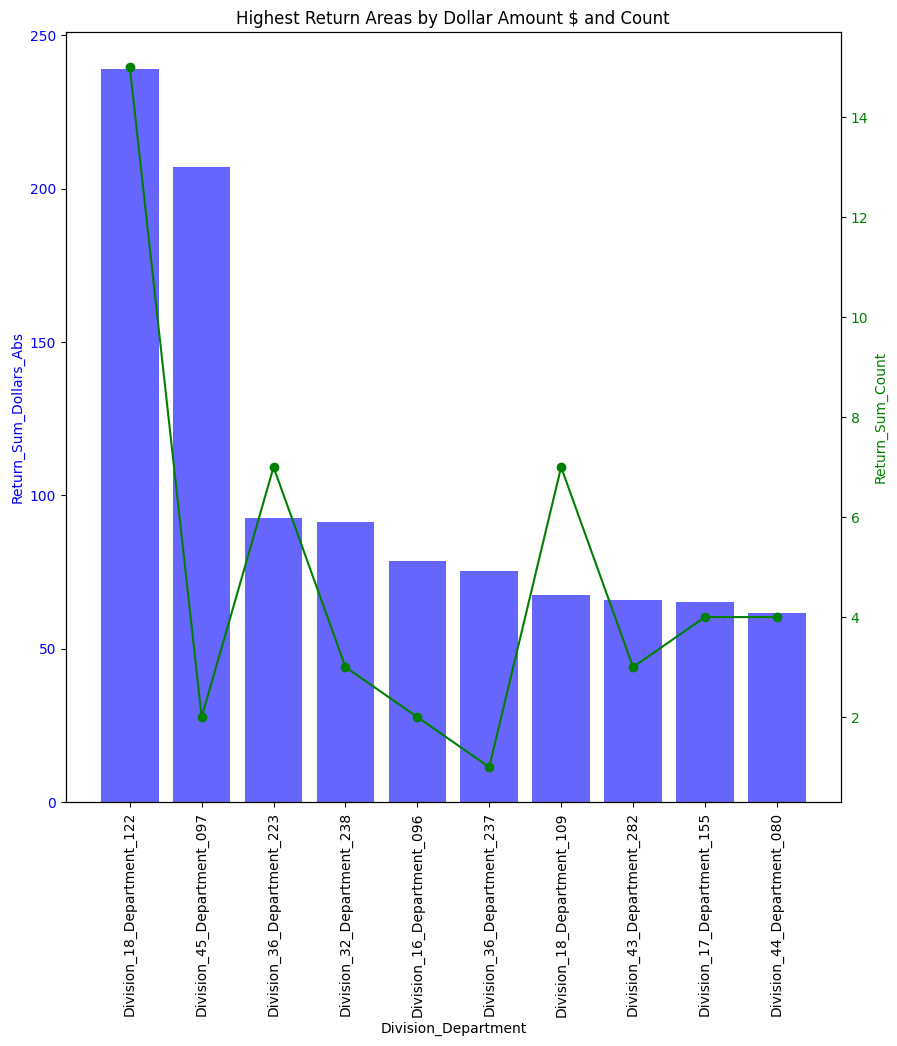

In [24]:
# Combine 'Division_Name' and 'Department_Name' into a new column
df_view['Division_Department'] = df_view['Division_Name'] + '_' + df_view['Department_Name']

# Take the absolute value of 'Return_Sum_Dollars'
df_view['Return_Sum_Dollars_Abs'] = df_view['Return_Sum_Dollars'].abs()

# Create the initial plot for the absolute value of 'Return_Sum_Dollars'
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.bar(df_view['Division_Department'], df_view['Return_Sum_Dollars_Abs'], color='b', alpha=0.6, label='Return_Sum_Dollars_Abs')
ax1.set_xlabel('Division_Department')
ax1.set_ylabel('Return_Sum_Dollars_Abs', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Set the x-tick locations and labels
ax1.set_xticks(range(len(df_view['Division_Department'])))  # Set x-tick locations
ax1.set_xticklabels(df_view['Division_Department'], rotation=90)  # Set x-tick labels

# Create a second y-axis to plot 'Return_Sum_Count'
ax2 = ax1.twinx()
ax2.plot(df_view['Division_Department'], df_view['Return_Sum_Count'], color='g', marker='o', label='Return_Sum_Count')
ax2.set_ylabel('Return_Sum_Count', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title("Highest Return Areas by Dollar Amount $ and Count")
plt.show()

## Results & Conclusions
### Key Findings:
Security Incidents Across Store Formats: StoreFormat_47 exhibited the highest average security incidents per store. It is critical that additional security measures are implemented in these stores to curb incidents and maintain a safe environment for customers and staff.

States with Highest Theft: The states with the most alarming rates of average recorded daily theft are State_38, State_03, and State_20. It appears that loss prevention measures may need to be concentrated more intensively in these geographical areas.

Impact of Recent Boycott on Sales: There is substantial evidence to suggest that the recent boycotts are affecting store performance. Sales have been in decline year-over-year, but a sharp decline is observed in 2023, with the month of July experiencing a drastic 60.18% drop in sales compared to the same month in the previous year.

Employee Reporting of Empty Packages: Employees with IDs 231, 098, and 196 have reported the highest number of empty packages for the current month. The data also indicates that high-value items may be more susceptible to theft or loss, as inferred from the high retail sum despite a low item count reported by Employee 098.
### Recommendations:
Allocate More Security Resources: Given the high rate of security incidents at StoreFormat_47 locations, it would be advisable to allocate more security resources, both human and technological, to these stores.

Targeted Loss Prevention: With States 38, 03, and 20 facing higher theft averages, loss prevention initiatives should focus more on these regions. This may include installing advanced security systems and conducting frequent security audits.

Investigate the Impact of Boycotts: The drastic drop in sales indicates that the boycott is affecting store performance. A thorough analysis of customer sentiment and public relations effectiveness should be conducted to formulate strategies to reverse this trend.

Investigate Employee Reports: Given the high reporting of empty packages by specific employees, it might be beneficial to dig deeper into the circumstances around these reports. This includes both recognizing the vigilance of these employees and understanding whether these specific store sections are more prone to theft or loss.